In [8]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_mps_initializer.datatypes import QuantumState
from qiskit.quantum_info import partial_trace, DensityMatrix, state_fidelity
import numpy as np
import matplotlib.pyplot as plt

# =============================
# === GLOBAL PARAMETERS ===
# =============================

psi = [1, 2, 3, 4, 5, 6, 7, 8]
phi = [1, 2, 3, 4, 5, 6, 7, 8]
n = 3
number_of_layers = 2

psi_state = QuantumState.from_dense_data(data=psi, normalize=True)
phi_state = QuantumState.from_dense_data(data=phi, normalize=True)
U_psi = psi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi = phi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi_dagger = U_phi.inverse()


# =============================
# === 1️⃣ Build experiment circuit ===
# =============================
def build_experiment_circuit(delta, m):
    psi_reg = QuantumRegister(n, "ψ")
    phi_reg = QuantumRegister(n, "φ")
    cregs = [ClassicalRegister(n, name=f"c{k}") for k in range(m)]
    qc = QuantumCircuit(psi_reg, phi_reg, *cregs)

    qc.append(U_psi, psi_reg)
    qc.append(U_phi, phi_reg)

    for k in range(m):
        # matching
        for i in range(n):
            qc.cx(phi_reg[n-1-i], psi_reg[n-1-i], ctrl_state=0)
        # controlled phase
        qc.mcp(delta, psi_reg[:-1], psi_reg[-1])
        # unmatch
        for i in range(n):
            qc.cx(phi_reg[i], psi_reg[i], ctrl_state=0)

        # measure ancilla
        qc.append(U_phi_dagger, phi_reg)
        qc.measure(phi_reg, cregs[k])
        qc.reset(phi_reg)

        if k < m - 1:
            qc.append(U_phi, phi_reg)

    return qc

In [9]:
def run_successful_shot(delta, m, max_trials=200):
    """
    Run the measurement-based circuit until we observe ancilla=000...0
    in all m rounds. Returns True if success, else False.
    """
    sim = AerSimulator()
    qc = build_experiment_circuit(delta, m)
    tqc = transpile(qc, sim)

    zero_state = "0" * n

    for trial in range(max_trials):
        shots = 5
        result = sim.run(tqc, shots=shots, memory=True).result()
        mem = result.get_memory(tqc)[0]
        parts = mem.split(" ")
        if all(p == zero_state for p in parts):
            print(f"✅ Success for m={m} (trial {trial+1}) → {mem}")
            return True
    print(f"❌ No success for m={m} after {max_trials} trials.")
    return False

In [10]:
def run_statevector_fidelity(delta, m):
    """
    Run deterministic version (no measurement) and compute ψ-fidelity vs ideal.
    """
    psi_reg = QuantumRegister(n, "ψ")
    phi_reg = QuantumRegister(n, "φ")
    qc = QuantumCircuit(psi_reg, phi_reg)
    qc.append(U_psi, psi_reg)
    qc.append(U_phi, phi_reg)

    for _ in range(m):
        for i in range(n):
            qc.cx(phi_reg[n-1-i], psi_reg[n-1-i], ctrl_state=0)
        qc.mcp(delta, psi_reg[:-1], psi_reg[-1])
        for i in range(n):
            qc.cx(phi_reg[i], psi_reg[i], ctrl_state=0)

    qc.save_statevector()
    sim = AerSimulator(method="statevector")
    result = sim.run(transpile(qc, sim)).result()
    full_state = result.get_statevector(qc)

    # partial trace to ψ subsystem
    rho_psi = partial_trace(full_state, list(range(n, 2*n)))

    # ideal ψ state
    psi_vec = np.array(psi) / np.linalg.norm(psi)
    phi_vec = np.array(phi) / np.linalg.norm(phi)
    phase_profile = np.exp(1j * delta * m * np.abs(phi_vec)**2)
    ideal_vec = psi_vec * phase_profile
    rho_ideal = DensityMatrix(ideal_vec)

    fid = state_fidelity(rho_psi, rho_ideal)
    return fid


In [11]:
def fidelity_vs_iterations_success_only(delta, max_m, max_trials=20):
    """
    For each iteration m:
      - Run measurement-based circuit until success
      - If success, compute fidelity from statevector simulation
    """
    fidelities = []
    for m in range(1, max_m+1):
        success = run_successful_shot(delta, m, max_trials=max_trials)
        if success:
            fid = run_statevector_fidelity(delta, m)
            print(f"  Fidelity for m={m}: {fid:.4f}")
            fidelities.append(fid)
        else:
            fidelities.append(np.nan)
    return fidelities

✅ Success for m=1 (trial 1) → 000
  Fidelity for m=1: 0.9991
✅ Success for m=2 (trial 1) → 000 000
  Fidelity for m=2: 0.9963
✅ Success for m=3 (trial 1) → 000 000 000
  Fidelity for m=3: 0.9917
✅ Success for m=4 (trial 1) → 000 000 000 000
  Fidelity for m=4: 0.9853
✅ Success for m=5 (trial 1) → 000 000 000 000 000
  Fidelity for m=5: 0.9772
✅ Success for m=6 (trial 1) → 000 000 000 000 000 000
  Fidelity for m=6: 0.9673
✅ Success for m=7 (trial 1) → 000 000 000 000 000 000 000
  Fidelity for m=7: 0.9558
✅ Success for m=8 (trial 1) → 000 000 000 000 000 000 000 000
  Fidelity for m=8: 0.9426
✅ Success for m=9 (trial 1) → 000 000 000 000 000 000 000 000 000
  Fidelity for m=9: 0.9280
✅ Success for m=10 (trial 1) → 000 000 000 000 000 000 000 000 000 000
  Fidelity for m=10: 0.9120
✅ Success for m=11 (trial 1) → 000 000 000 000 000 000 000 000 000 000 000
  Fidelity for m=11: 0.8946
✅ Success for m=12 (trial 1) → 000 000 000 000 000 000 000 000 000 000 000 000
  Fidelity for m=12: 0.876

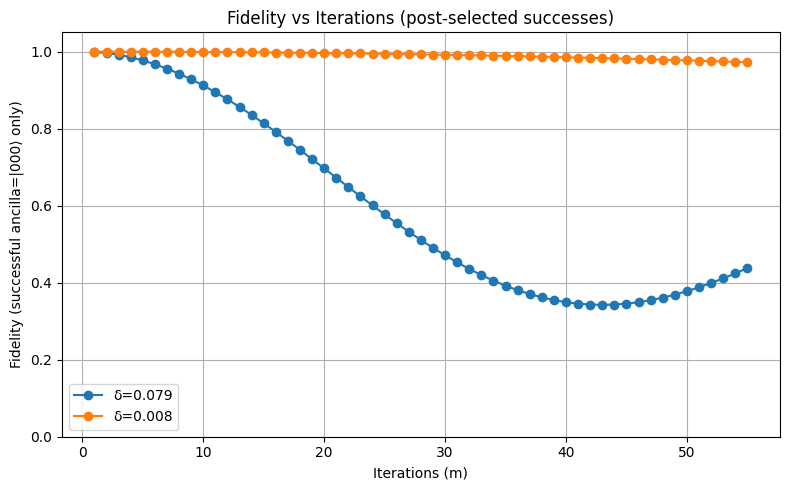

In [13]:
def plot_fidelity_vs_iterations(delta_values, max_m):
    plt.figure(figsize=(8,5))
    for delta in delta_values:
        fidelities = fidelity_vs_iterations_success_only(delta, max_m)
        m_values = np.arange(1, max_m+1)
        plt.plot(m_values, fidelities, "o-", label=f"δ={delta:.3f}")
    plt.xlabel("Iterations (m)")
    plt.ylabel("Fidelity (successful ancilla=|000⟩ only)")
    plt.title("Fidelity vs Iterations (post-selected successes)")
    plt.legend()
    plt.grid(True)
    plt.ylim(0,1.05)
    plt.tight_layout()
    plt.show()


# =============================
# === Example usage ===
# =============================
delta_values = [np.pi/40, np.pi/400]
plot_fidelity_vs_iterations(delta_values, max_m=55)